In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

2.4.1
TensorFlow version: 2.4.1
Keras version: 2.4.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
classes = pd.read_csv("data/Train.csv")

min_width, max_width = max(classes.Width), min(classes.Width)
min_height, max_height = max(classes.Height), min(classes.Height)

print(np.mean([min_width, max_width]))
print(np.mean([min_height, max_height]))

134.0
125.0


In [4]:
classes_no = len(classes.ClassId.unique())
print("There are {} unique classes in the dataset.".format(classes_no))

There are 43 unique classes in the dataset.


#### Load a pre-trained model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(input_shape=(125, 125, 3), weights='imagenet', include_top=False)

In [ ]:
base_model.summary()

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dropout layer to avoid overfitting (drop 20%)
# and a logistic layer
predictions = Dense(classes_no, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])

Load the data and use data augmentation

In [5]:
cwd = os.getcwd()
base_dir = os.path.join(cwd, 'data')
train_path= os.path.join(base_dir, 'Train')
test_path= os.path.join(base_dir, 'Test')

In [6]:
BATCH_SIZE = 20
TARGET_SIZE = (32, 32)

In [27]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_crossentropy', patience=10)

In [ ]:
history = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=100,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      validation_freq=10,
      callbacks = [callback],
      verbose=1)

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = model.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=50,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('trained_model/my_model_50_epochs') 

### Load saved model

In [ ]:
model_path = os.path.join(cwd, "trained_model/my_model_50_epochs")
model = tf.keras.models.load_model(model_path)

In [ ]:
results = model.evaluate(test_data, batch_size=200)

In [ ]:
import glob
test_image_path = glob.glob('Data/Test/*.*')

In [ ]:
labels = np.expand_dims(test_labels, axis=1)

In [ ]:
data = []

for img in test_image_path[0:1000]:   
    img = tf.keras.preprocessing.image.load_img(img, target_size=(125, 125))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x/255
    data.append(x)

In [ ]:
results = model.evaluate(test_data, batch_size=100)

In [ ]:
predictions = np.argmax(model.predict(test_data, steps=1), axis=1)

In [ ]:
test_labels_com=[]

for i in range(len(predictions)):
    img, label = test_data.next()
    l = np.argmax(label[0])
    print(l, predictions[i])
    test_labels_com.append(l)
    plt.imshow(img[0])
    plt.show()

In [ ]:
number_of_examples

In [ ]:
import math

number_of_examples = len(test_data.filenames)
#number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 1)) 

test_labels_com = []

for i in range(0, int(number_of_examples)):
    test_labels_com.append(np.argmax(test_data[i][1]))

In [ ]:
test_labels_com

In [ ]:
tf.stack([np.argmax(predictions, axis=1), test_labels_com], axis=1)

LeNEt 5 model    

In [16]:
def leNet():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(layers.AveragePooling2D())

    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=500, activation='relu'))

    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(units=43, activation = 'softmax'))
    
    return model

In [17]:
from tensorflow.keras.optimizers import SGD

lenet = leNet()
lenet.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=400,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/400
1568/1568 [==============================] - 291s 186ms/step - loss: 2.3941 - accuracy: 0.2990 - val_loss: 2.3783 - val_accuracy: 0.2681
Epoch 2/400
1568/1568 [==============================] - 270s 172ms/step - loss: 2.3907 - accuracy: 0.3000 - val_loss: 2.3871 - val_accuracy: 0.2714
Epoch 3/400
1568/1568 [==============================] - 38s 24ms/step - loss: 2.3915 - accuracy: 0.3009 - val_loss: 2.3701 - val_accuracy: 0.2774
Epoch 4/400
1568/1568 [==============================] - 38s 24ms/step - loss: 2.3820 - accuracy: 0.3022 - val_loss: 2.3565 - val_accuracy: 0.2798
Epoch 5/400
1568/1568 [==============================] - 38s 24ms/step - loss: 2.3797 - accuracy: 0.3044 - val_loss: 2.3623 - val_accuracy: 0.2815
Epoch 6/400
1568/1568 [==============================] - 38s 24ms/step - loss: 2.3771 - accuracy: 0.3049 - val_loss: 2.3408 - val_accuracy: 0.2828
Epoch 7/400
1568/1568 [==============================] - 37s 24ms/step - loss: 2.3687 - accuracy: 0.3075 - val_los

KeyboardInterrupt: 

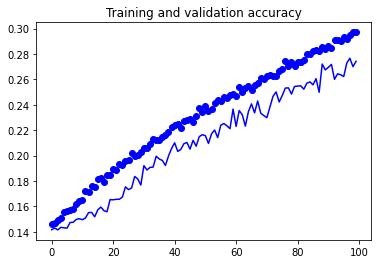

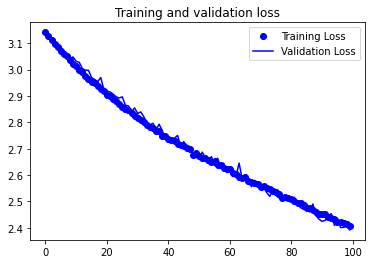

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
lenet.save('trained_model/lenet_500_epochs') 

INFO:tensorflow:Assets written to: trained_model/lenet_500_epochs\assets


In [25]:
BATCH_SIZE = 200
TARGET_SIZE = (32, 32)

In [28]:
# Create a data generator for the training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%

# Create a data generator for the validation images
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

#Split data to training and validation datasets
train_data = train_datagen.flow_from_directory(train_path, 
                                               target_size=TARGET_SIZE, 
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=2,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory(train_path, 
                                           target_size=TARGET_SIZE, 
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=2,
                                           subset = 'validation')

datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(test_path,
                                        target_size=TARGET_SIZE, 
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [31]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = lenet.fit(
      train_data,
      steps_per_epoch= train_data.samples // BATCH_SIZE,  # One pass through entire training dataset
      epochs=50,
      validation_data=val_data,
      validation_steps= val_data.samples // BATCH_SIZE,  # One pass through entire validation dataset
      #validation_freq=10,
      verbose=1)

Epoch 1/50
156/156 [==============================] - 28s 179ms/step - loss: 1.4984 - accuracy: 0.5241 - val_loss: 1.6963 - val_accuracy: 0.4779
Epoch 2/50
156/156 [==============================] - 28s 179ms/step - loss: 1.4985 - accuracy: 0.5267 - val_loss: 1.6989 - val_accuracy: 0.4763
Epoch 3/50
156/156 [==============================] - 28s 180ms/step - loss: 1.5042 - accuracy: 0.5278 - val_loss: 1.6896 - val_accuracy: 0.4783
Epoch 4/50
156/156 [==============================] - 28s 178ms/step - loss: 1.5037 - accuracy: 0.5262 - val_loss: 1.6932 - val_accuracy: 0.4827
Epoch 5/50
156/156 [==============================] - 28s 181ms/step - loss: 1.5091 - accuracy: 0.5250 - val_loss: 1.6976 - val_accuracy: 0.4767
Epoch 6/50
156/156 [==============================] - 28s 182ms/step - loss: 1.5083 - accuracy: 0.5220 - val_loss: 1.6925 - val_accuracy: 0.4791
Epoch 7/50
156/156 [==============================] - 30s 193ms/step - loss: 1.5047 - accuracy: 0.5293 - val_loss: 1.6971 - val_ac